In [1]:
# from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import statsmodels.api as sm
import scipy.stats as sps

pd.options.mode.chained_assignment = None  # default='warn'
%load_ext autoreload
%autoreload 2

In [2]:
from utils_plot import set_plt_settings, plot_ts_model
from utils_data import NODES, PATH_DATA, make_analysis_dataset
from utils_mdp import train_valueit_model, test_valueit_model
from utils_battery import discretize_e_states, get_efficiency
from utils_cv import train_test_split, crossval_model

set_plt_settings()

# 0. Make analytic datasets
## 0.1 Read in data

In [ ]:
node = NODES[0]
# read in data
df = make_analysis_dataset(nodes=[node])

# set columns
mark_cols = ['lmp_rt_m1', 'lmp_rt_m2'] + ['lmp_da', 'hour', 'weekday']
node_cols = [col for col in df.columns if col.startswith(('node'))] 

## 0.2 Evaluate transition model
Need model to predict next period's realtime price. I use linear regression. Big room for improvement on this project is improving this transition model

In [4]:
# train test split
df['half'] = (df.quarter > 2)*1.
X_tt, y_tt, g_tt, X_val, y_val = train_test_split(df, X_cols=mark_cols + node_cols, y_col='lmp_rt', 
                                                   group_cols=['year', 'half'], yr_val=2022)

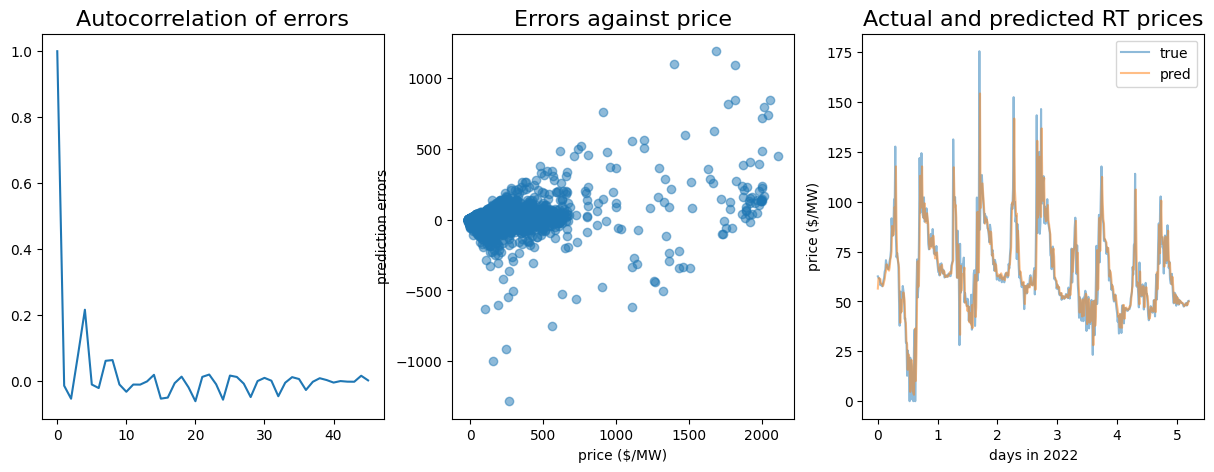

In [5]:
# train model
tmodel = sm.OLS(endog=y_val, exog=X_val).fit(disp=0, robust_cov='HC0')
plot_ts_model(tmodel, X_val, y_val, t=500)

# 1. Model-based value iteration using value function approximation
Improvements to transition model: ARIMA model to incorporate moving average, Cube root transformation

## 1.1 Set parameters

In [6]:
# col params
X_cols = mark_cols + node_cols + ['lmp_rt_m1_rolling']
y_col = 'lmp_rt'
group_cols = ['year']

# battery params
b_params = {'dur':100, 'capacity':200}
b_params['efficiency'] = get_efficiency(b_params['dur'])

# state params
S = 3000
kmax=100

# hyperparams
hp_weights = [0.33, 0.33]
hp_ma_com = [0.8]

## 1.2 Grid search

In [7]:
# grid search
hp_weight_notrev = [0.25, 0.5, 0.66, 1.]
hp_weight_split = [0.5, 1.]
hp_ma = [0.5, 1]

In [9]:
gssum = {}
gssummean = {}
hp_weights_log = []
for wr in hp_weight_notrev:
    for ws in hp_weight_split:
        hp_weights = [wr*ws, wr*(1-ws)]
        hp_weights_log += [hp_weights]
        for ma in hp_ma:
            # redefine rolling period
            df['lmp_rt_m1_rolling']  = df.lmp_rt_m1.ewm(com=ma).mean()
            # split data
            X_tt, y_tt, g_tt, X_val, y_val = train_test_split(df, X_cols, y_col, group_cols, yr_val=2022)
            # cross validate
            label = f'weights={hp_weights + [1-wr]}, ma={ma}'
            cvsum, cvsummean = crossval_model(X_tt, y_tt, g_tt, hp_weights, b_params, S, kmax, desc=label)
            print('revenue (mean, range):', cvsummean['cumrev'], cvsummean['cumrev_range'])
            gssum[(wr*ws, wr*(1-ws), ma)] = cvsum
            gssummean[(wr*ws, wr*(1-ws), ma)] = cvsummean

weights=[0.125, 0.125, 0.75], ma=0.5:   0%|               | 0/2 [01:21<?, ?it/s]


KeyboardInterrupt: 

## 1.3 Select best hyperparameters

In [ ]:
summ = pd.DataFrame([])
for k, v in gssum.items():
    d = pd.DataFrame(v)
    d['w_roll'], d['w_e'], d['ma'] = k[0], k[1], k[2]
    summ = pd.concat([d, summ])
    
summ.to_csv(f'{PATH_RESULTS}hptune_summ_{node.lower()}_{dur}.csv', index=False)

In [11]:
# define file locations
PATH_RESULTS = f'{PATH_DATA}results/'
# start from previous hyperparam tuning
summ = pd.read_csv(f'{PATH_RESULTS}hptune_summ_{node.lower()}_{b_params["dur"]}.csv')

summmean = summ.groupby(['w_roll', 'w_e', 'ma']).mean().reset_index()

# store best
opt_idx = summmean.cumrev.argmax()
hp_optimal = summmean.iloc[opt_idx].values[:3]
# hp_optimal = np.array([0.5, 0, 0.8])
print('best params:', hp_optimal, f'(mean cumrev={summmean.cumrev.max()})')

## 1.4 Evaluate on full dataset

In [14]:
df['lmp_rt_m1_rolling']  = df.lmp_rt_m1.ewm(com=hp_optimal[1]).mean()
X_tt, y_tt, g_tt, X_val, y_val = train_test_split(df, X_cols, y_col, group_cols, yr_val=2022)

### 1.4.a Train on full training data

In [16]:
Utheta, U_theta_log = train_valueit_model(X_tt, y_tt, hp_optimal[:2], b_params, S*2, kmax, verbose=True)

train:  53%|██████████████████▌                | 53/100 [02:42<02:24,  3.07s/it]


KeyboardInterrupt: 

In [ ]:
# look at convergence in U_theta
plt.figure(figsize=(10, 5))
for i, e in enumerate(discretize_e_states(b_params)):
    plt.plot(U_theta_log[:, i], alpha=0.5, label=f'{int(e)}MWh')
    
plt.legend()
plt.ylabel('Max % change in U_theta')
plt.xlabel('iteration')
plt.ylim((0, 1))
plt.show()

### 1.4.b Evaluate on hold-out data

In [69]:
hp_optimal = np.array([0.5, 0, 0.8])
ace, revenue = test_valueit_model(X_val, y_val, Utheta, hp_optimal[:2], b_params, verbose=True)

test: 100%|██████████████████████████████| 35035/35035 [01:19<00:00, 438.94it/s]


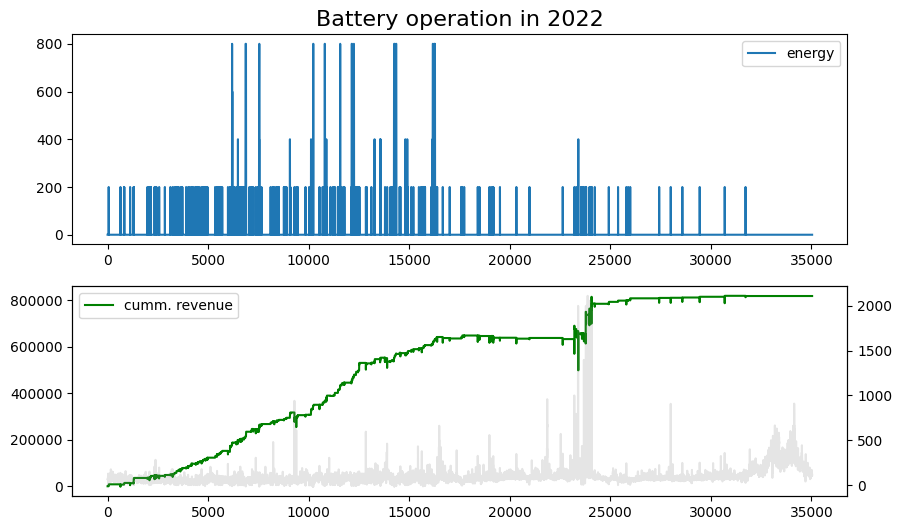

In [70]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 6))
ax1r = ax[1].twinx()
ax[0].plot(ace[2], label='energy')
ax1r.plot(y_val, color='grey', alpha=0.2)
ax[1].plot(np.cumsum(revenue), label='cumm. revenue', color='green')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Battery operation in 2022')
plt.show()